In [1]:
#instalacja pakietu gdown
!pip install -U --no-cache-dir gdown --pre

#usuwanie i tworzenie pustego katalogu data
!rm -rf data && mkdir data

#pobieranie zip-a ze zdjęciami
!gdown 1uz5VjUQv4hz8txJU5p3qxe2-nWKUNxMb -O data.zip

#rozpakowywanie pliku data.zip do katalogu data
!unzip -q data.zip -d data

Downloading...
From: https://drive.google.com/uc?id=1uz5VjUQv4hz8txJU5p3qxe2-nWKUNxMb
To: /content/data.zip
100% 19.5M/19.5M [00:00<00:00, 27.7MB/s]


In [2]:
import xml.etree.ElementTree as ET
import os

tree = ET.parse('data/annotations.xml')
root = tree.getroot()

for child in root:
  if child.tag == 'image':
    image_name = child.attrib['name']
    image_label = child[0].attrib['label']

    if not os.path.isdir(f'data/{image_label}'):
      os.mkdir(f'data/{image_label}')

    os.replace(f'data/{image_name}', f'data/{image_label}/{image_name}')

    #print(f'image with name {image_name} has label {image_label}')

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import glob

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
image_count = len(list(glob.glob('data/**/*.png')))
print(f'{image_count} examples of games')

140 examples of games


In [5]:
minecraft_count = len(list(glob.glob('data/minecraft/*.png')))
wiedzmin_count = len(list(glob.glob('data/wiedzmin/*.png')))
cyberpunk_count = len(list(glob.glob('data/cyberpunk/*.png')))
gta_count = len(list(glob.glob('data/gta/*.png')))
print(f'examples of minecraft: {minecraft_count}, wiedzmin: {wiedzmin_count}, cyberpunkt:{cyberpunk_count}, gta:{gta_count}')

examples of minecraft: 35, wiedzmin: 35, cyberpunkt:35, gta:35


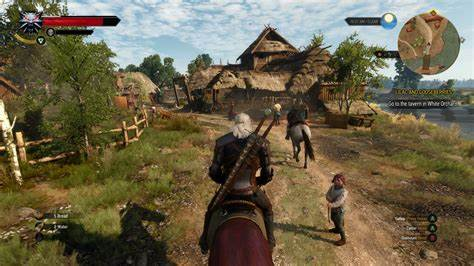

In [6]:
mc = list(glob.glob('data/minecraft/*'))
wiedz = list(glob.glob('data/wiedzmin/*'))
cyb = list(glob.glob('data/cyberpunk/*'))
gta = list(glob.glob('data/gta/*'))

PIL.Image.open(str(wiedz[1]))

In [7]:
batch_size = 32
class_count = 4

img_height = 64
img_width = 64

In [46]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  'data',
  validation_split=0.2,
  subset='training',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  'data',
  validation_split=0.2,
  subset='validation',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 140 files belonging to 4 classes.
Using 112 files for training.
Found 140 files belonging to 4 classes.
Using 28 files for validation.


In [47]:
class_names = train_ds.class_names
print(f'class names: {class_names}')

class names: ['cyberpunk', 'gta', 'minecraft', 'wiedzmin']


In [48]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [49]:
def get_model(type='custom'):
  model = None
  if type == 'resnet_transfer':
    base_model = tf.keras.applications.ResNet50(
            include_top=False,
            input_shape=(img_height, img_width, 3),
            classes=class_count,
        )
    x = layers.GlobalAveragePooling2D()(base_model.output)

    # Add a fully connected layer with a sigmoid activation for binary classification
    predictions = layers.Dense(class_count, activation='sigmoid')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

  elif type == 'resnet':
    model = tf.keras.applications.ResNet50(
            weights=None,
            input_shape=(img_height, img_width, 3),
            classes=class_count,
        )

  elif type == 'custom':
    model = Sequential([
      layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(class_count)
    ])

  return model


In [50]:
model = get_model('custom')
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 64, 64, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 548,516 (2.09 MB)

 Trainable params: 548,516 (2.09 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
import os
import cv2

def is_valid_image(file_path):
    try:
        img = cv2.imread(file_path)
        return img is not None
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return False

def remove_invalid_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            if not is_valid_image(file_path):
                print(f"Removing invalid image: {file_path}")
                os.remove(file_path)

# Remove invalid files from the data directory
remove_invalid_images('data')

In [52]:
import os
from PIL import Image

def convert_images_to_png(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            if not file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                print(f"Skipping non-image file: {os.path.join(root, file)}")
                continue
            try:
                img_path = os.path.join(root, file)
                with Image.open(img_path) as img:
                    # Convert image to RGB mode if it's not already
                    if img.mode != 'RGB':
                        img = img.convert('RGB')
                    # Save the image in PNG format
                    new_img_path = os.path.splitext(img_path)[0] + '.png'
                    img.save(new_img_path, 'PNG')
                    # Remove the original image if it's not PNG
                    if not file.lower().endswith('.png'):
                        os.remove(img_path)
                    #print(f"Converted and saved: {new_img_path}")
            except Exception as e:
                print(f"Failed to convert {img_path}: {e}")

# Convert all images in the 'data' directory to PNG
convert_images_to_png('data')

In [53]:
epochs=40
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 583ms/step - accuracy: 0.1996 - loss: 1.4190 - val_accuracy: 0.2143 - val_loss: 1.4228
Epoch 2/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.3280 - loss: 1.3414 - val_accuracy: 0.2500 - val_loss: 1.3891
Epoch 3/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.4603 - loss: 1.2638 - val_accuracy: 0.2857 - val_loss: 1.3529
Epoch 4/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.5478 - loss: 1.1216 - val_accuracy: 0.3214 - val_loss: 1.3491
Epoch 5/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.6363 - loss: 0.9235 - val_accuracy: 0.3214 - val_loss: 1.4286
Epoch 6/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.7631 - loss: 0.7382 - val_accuracy: 0.3929 - val_loss: 1.5602
Epoch 7/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.6660 - loss: 0.7313 - val_accuracy: 0.6071 - val_loss: 1.2061
Epoch 8/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.8319 - loss: 0.4823 - val_accuracy: 0.3571 - val_loss:

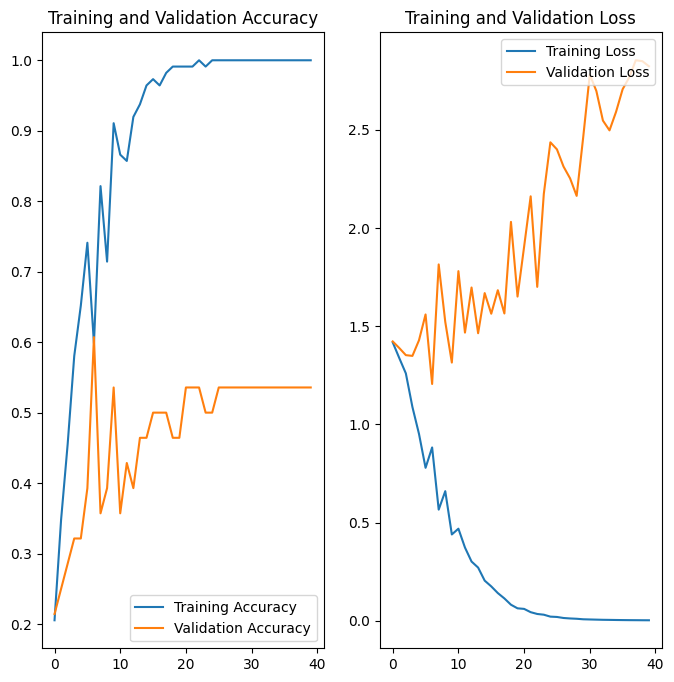

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [55]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(val_ds, model):
    y_pred = []
    y_true = []

    for batch_images, batch_labels in val_ds:
        predictions = model.predict(batch_images, verbose=0)
        y_pred = y_pred + np.argmax(tf.nn.softmax(predictions), axis=1).tolist()
        y_true = y_true + batch_labels.numpy().tolist()

    cm = confusion_matrix(y_true, y_pred)
    print(classification_report(y_true, y_pred, target_names=class_names))
    print(cm)

    return cm

cm = evaluate_model(val_ds, model)
#support - how many examples in the test data belonging to a given class

              precision    recall  f1-score   support

   cyberpunk       0.22      0.67      0.33         3
         gta       0.75      0.33      0.46         9
   minecraft       0.67      1.00      0.80         6
    wiedzmin       0.67      0.40      0.50        10

    accuracy                           0.54        28
   macro avg       0.58      0.60      0.52        28
weighted avg       0.65      0.54      0.53        28

[[2 0 1 0]
 [3 3 1 2]
 [0 0 6 0]
 [4 1 1 4]]


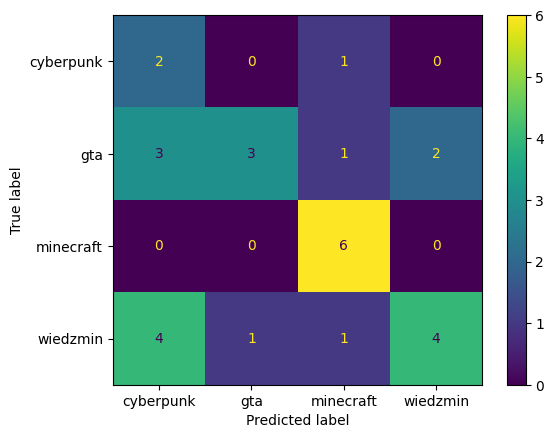

In [56]:
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()